# Music Recommendation System

This workbook is developed as part of the final project for MIDS W207 - Applied Machine Learning at University of Berkeley. 

This project we explored the differnt machine learning algorithms (Decision Tree, Random Forest, and Gradient Boosting Machine) on the kkbox music dataset. (from [kkbox](https://www.kkbox.com/intl/index.php?area=intl)) 

A Recommender System is a process that seeks to predict user preferences.The recommender system aims to predict users' choices or interests, and based on these recommend the product items. There are multiple types of recommendation system as shown in the [chart]() below. It deals with large volume of information present by filtering the most important information based on the data provided by a user and other factors that take care of the user’s preference and interest. It finds out the right match between user and item and imputes the similarities between users and items for recommendation.

The organization of the jupyter notebook as presented below: 

#### Table of Contents:
* [What are Music Recommendation Systems?](#first-bullet)
* [Business Problem and Problem Statement for the project](#second-bullet)
* [Exploratory Data Analysis ](#third-bullet)
* [Data Processing & Feature Engineering](#fourth-bullet)
* [Building Models](#fifth-bullet)
* [Discussion on Results](#sixth-bullet)
* [Way-forward](#seventh-bullet)
* [References](#eigth-bullet)

## What are Music Recommendation Systems? <a class="anchor" id="first-bullet"></a>


Music Recommendation Systems are a type of Recommendation Systems which based on the the predicted user preferences recommend songs subject to multitude of factors. This systems in the past have become popular as the number of songs available exceeds the search and listening capacity of an individual and with jukebox and radio becoming obselete there is a good chance on missing out on songs that an individual would like to listen. 

Thus, Music service providers need an efficient way to manage songs and help their customers to discover music by giving a quality recommendation. For building this recommendation system, they deploy machine learning algorithms to process data from a million sources and present the listener with the most relevant songs.

There are mainly three types of recommendation system: **content-based**, **collaborative** and **popularity**. 

The **content-based** algorithms are given user preferences for items and recommend similar items based on a domain-specific notion of item content. This approach also extends naturally to cases where item metadata is available (e.g., movie stars, book authors, and music genres). 

The **collaborative-based** system perhaps the most well-known approach to recommendation, to the point that it’s sometimes seen as synonymous with the field. The main idea is that you’re given a matrix of preferences by users for items, and these are used to predict missing preferences and recommend items with high predictions.

The **popularity-based** system predicts based on the most popular songs amongst the users, however personalization in such a system is not possible. 

In this case study, we will be looking towards some good techniques to recommend music to brand new as well as existing users. By building this system, we aim to provide a better user experience for the app users.

## Business Problem and Problem Statement <a class="anchor" id="second-bullet"></a>


The 11th ACM International Conference on Web Search and Data Mining (WSDM 2018) challenged to build a better music recommendation system using a donated dataset from KKBOX. WSDM (pronounced “wisdom”) is one of the premier conferences on web inspired research involving search and data mining.

The glory days of Radio DJs have passed, and musical gatekeepers have been replaced with personalizing algorithms and unlimited streaming services. With easy access to various kinds of music across the globe, public is now listening to all kinds of music. Existing algorithms, however, struggle in key areas. Without enough historical data, how would an algorithm know if listeners will like a new song or a new artist? And how would it know what songs to recommend brand new users?

The dataset is from KKBOX, Asia’s leading music streaming service, holding the world’s most comprehensive Asia-Pop music library with over 30 million tracks. The input contains text data only, and no audio features. They currently use a collaborative filtering based algorithm with matrix factorization and word embedding in their recommendation system but believe new techniques could lead to better results.

## Problem Statement 

* Predict the changes of a user re-listening to a song. Basically understand what factors effect the users changes of listening to songs

* What are the top five songs that are members more likely to listen to?

## Exploratory Data Analysis <a class="anchor" id="third-bullet"></a>

The data was made available by [kakkle](https://www.kaggle.com/c/kkbox-music-recommendation-challenge/data). 

Data files:
* members.csv: User profile data such as age, gender, city etc. 
* songs.csv: Information on the listed songs such as name, language, length, genre
* extra_song.csv: Extra information on the listed songs based on ISCR codes
* train.csv: member and source event information 

This is an important stage as we can dive deep into the data in this stage and derive useful insights which will then prove vital during Feature Engineering and Building Machine Learning Mode

In [1]:
%matplotlib inline
import re
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt 
import seaborn as sns 

from scipy.stats import norm
from scipy import stats
from collections import Counter
from sklearn import preprocessing
from langdetect import detect

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings("ignore")
color = sns.color_palette()

In [2]:
col_pals = ['ch:2.5,-.2,dark=.4',
            "ch:12,-.2,dark=.4",
            "ch:.12,0,dark=.4",
            "ch:7,-.2,dark=.4",
            "ch:2,0.3,dark=.4",
            "ch:23,0.3,dark=.4",
            "ch:10,-0.1,dark=.4"]

In [162]:
fp = "data/"
train = pd.read_csv(fp+"train.csv")
test=pd.read_csv(fp+"test.csv")
members=pd.read_csv(fp+"members.csv",parse_dates=['registration_init_time','expiration_date']) #reading the date format
songs=pd.read_csv(fp+"songs.csv")
extra_songs = pd.read_csv(fp+"song_extra_info.csv")

In [4]:
def summary(df):
    for i in df.columns:
        print("Distinct features in dataframe:{}".format(len(np.unique(df[i].astype('str')))))
        
def count_na(df):
    for i in df.columns:
        na_counted = df[i].isnull().sum()
        na_percentage = na_counted*100/df.shape[0]
        print(i,"....{} ....{:.2f}%".format(na_counted,na_percentage))

def genres_separate(genre_ids):
    
    genre_dictionary = {}
    for genre_id in genre_ids:
        if type(genre_id) != str:
            continue
        genre_list = genre_id.split('|')
        for genre in genre_list:
            if genre not in genre_dictionary:
                genre_dictionary[genre] = 1
            else:
                genre_dictionary[genre] += 1
    
    return genre_dictionary  

def sns_bar(df,x_name,y_name,title,pal, axis_rot=0):
    plt.figure(figsize=(15,8))
    ax = sns.barplot(x=x_name, y=y_name, 
                     data=df, palette=pal)
    ax.set_title(title, fontsize=15)
    
    if axis_rot ==1:
        ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
            
    plt.show()

Train Data Exploration

In [5]:
train.head(5)

,msno,song_id,source_system_tab,source_screen_name,source_type,target
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1


In [6]:
summary(train)

Distinct features in dataframe:30755
Distinct features in dataframe:359966
Distinct features in dataframe:9
Distinct features in dataframe:21
Distinct features in dataframe:13
Distinct features in dataframe:2


In [7]:
count_na(train) 

msno ....0 ....0.00%
song_id ....0 ....0.00%
source_system_tab ....24849 ....0.34%
source_screen_name ....414804 ....5.62%
source_type ....21539 ....0.29%
target ....0 ....0.00%


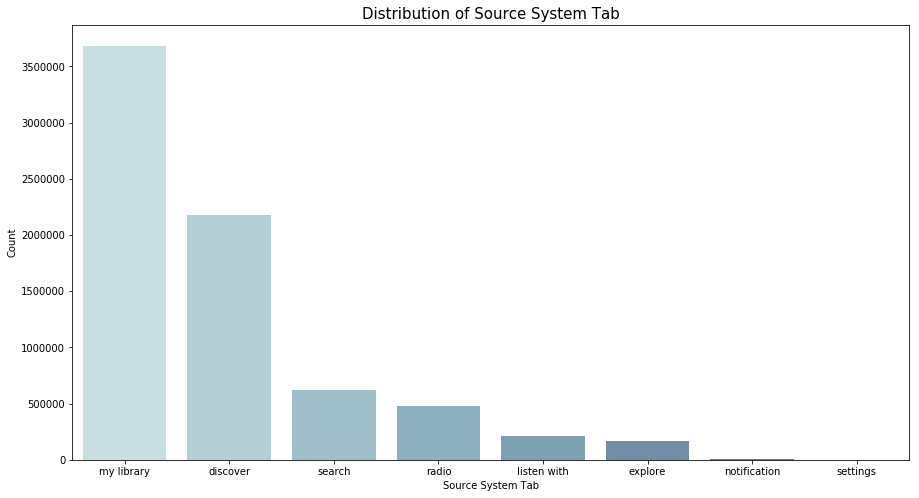

In [8]:
a = pd.DataFrame(train.groupby('source_system_tab').size()).reset_index(level=0)
a.columns = ['Source System Tab', 'Count']
a = a.sort_values(by='Count', ascending=False)

sns_bar(a,'Source System Tab', 'Count','Distribution of Source System Tab',col_pals[1])

the above plot shows that certain types of source system tabs such as **"my-library"** or **"discover"** have higher frequency of song events. This also looks intutive as we mostly use our libraries to listen to songs. Let us explore the same relation in respect of the repeat percentage to see which level of source system tab contributes maximum to repeat events

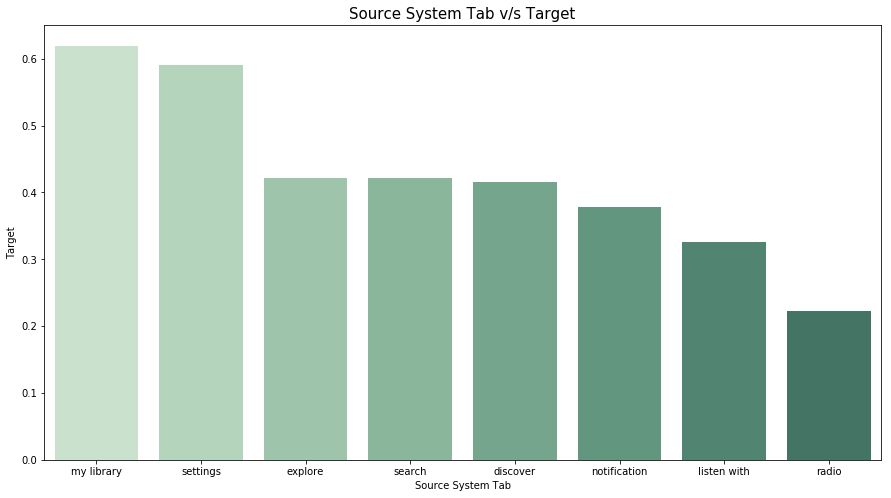

In [9]:
repeat_df = train.groupby(['source_system_tab']).mean().sort_values(by='target', ascending=False).reset_index(level=0)
repeat_df.columns = ['Source System Tab', 'Target']

sns_bar(repeat_df,'Source System Tab', 'Target','Source System Tab v/s Target',col_pals[0])


As suspected, my library has maxmium repeat percentage followed by settings, explore, serach and discover. Note that settings and explore have less events yet have high conversions.

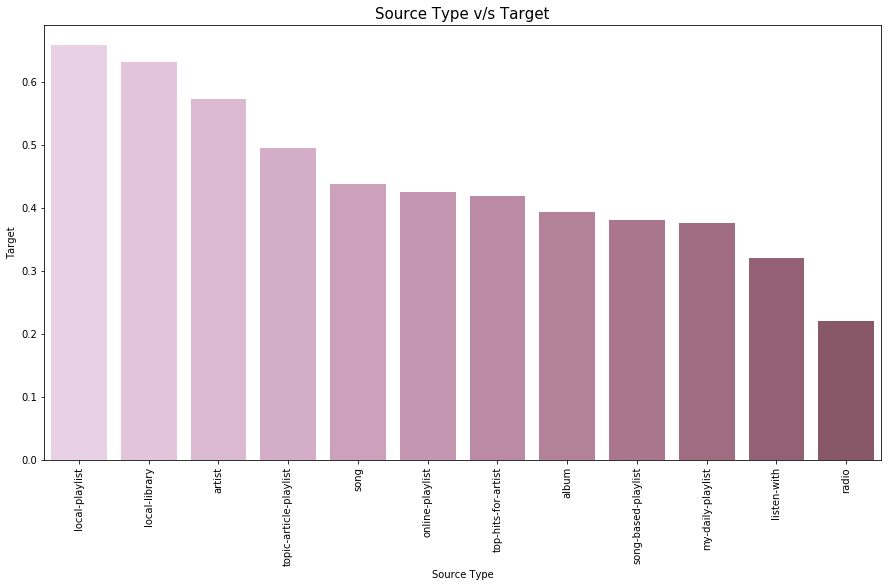

In [10]:
source_type = train.groupby(['source_type']).mean().sort_values(by='target', ascending=False).reset_index(level=0)
source_type.columns = ['Source Type', 'Target']

sns_bar(source_type,'Source Type', 'Target','Source Type v/s Target',col_pals[3],axis_rot=1)

Similar to previous observation, "My library" and "Local playlist" more has high events and repeat percentage as compared to others. Therefore it might be worth looking at the source type as well. 

Member data exploration

In [11]:
summary(members)

Distinct features in dataframe:34403
Distinct features in dataframe:21
Distinct features in dataframe:95
Distinct features in dataframe:3
Distinct features in dataframe:6
Distinct features in dataframe:3862
Distinct features in dataframe:1484


In [12]:
count_na(members)

msno ....0 ....0.00%
city ....0 ....0.00%
bd ....0 ....0.00%
gender ....19902 ....57.85%
registered_via ....0 ....0.00%
registration_init_time ....0 ....0.00%
expiration_date ....0 ....0.00%


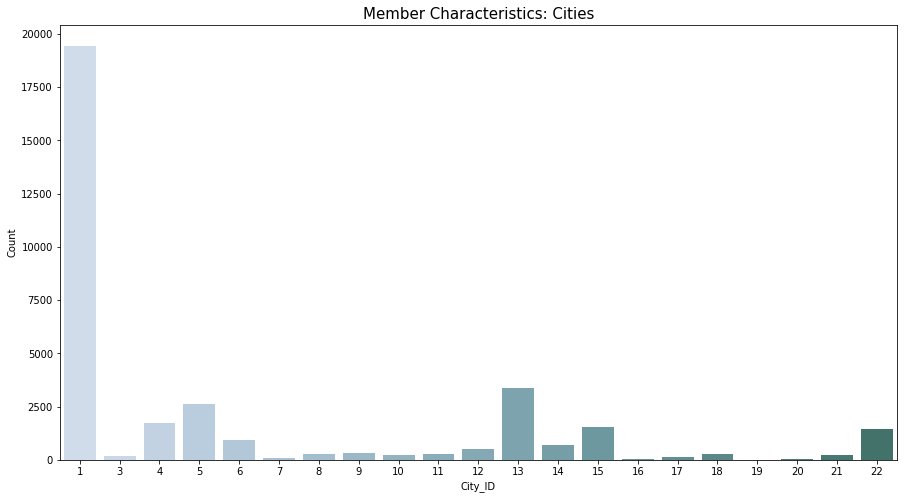

In [13]:
cities = pd.DataFrame(members.groupby(['city']).size()).reset_index(level=0)
cities.columns = ['City_ID', 'Count']

sns_bar(cities,'City_ID', 'Count','Member Characteristics: Cities',col_pals[4])

The data has more members for City code #1 as compared to the other places. Some cities have very few people who prefer listening music via this music app.

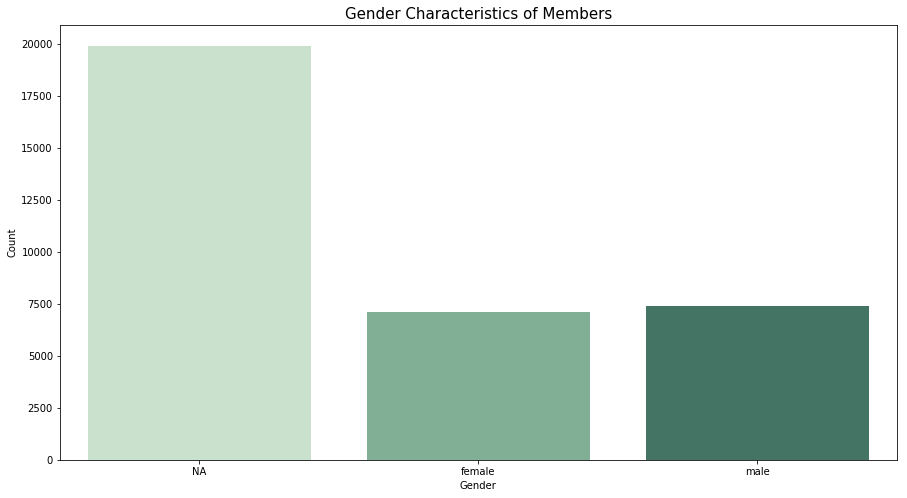

In [14]:
gender = pd.DataFrame(members.gender).replace(np.nan,'NA')
gender = pd.DataFrame(gender.groupby('gender').size()).reset_index(level=0)
gender.columns = ['Gender','Count']
sns_bar(gender,'Gender','Count','Gender Characteristics of Members',col_pals[0])

The above plot shows that the majority of the members have no information on the gender and for the ones available, the sex ratio of male to femaile is close to 1. 

In [27]:
members.head()

,msno,city,bd,gender,registered_via,registration_init_time,expiration_date,membership_days
0,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,0,NaN,7,2011-08-20,2017-09-20,11
1,UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=,1,0,NaN,7,2015-06-28,2017-06-22,3
2,D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=,1,0,NaN,4,2016-04-11,2017-07-12,2
3,mCuD+tZ1hERA/o5GPqk38e041J8ZsBaLcu7nGoIIvhI=,1,0,NaN,9,2015-09-06,2015-09-07,0
4,q4HRBfVSssAFS9iRfxWrohxuk9kCYMKjHOEagUMV6rQ=,1,0,NaN,4,2017-01-26,2017-06-13,0


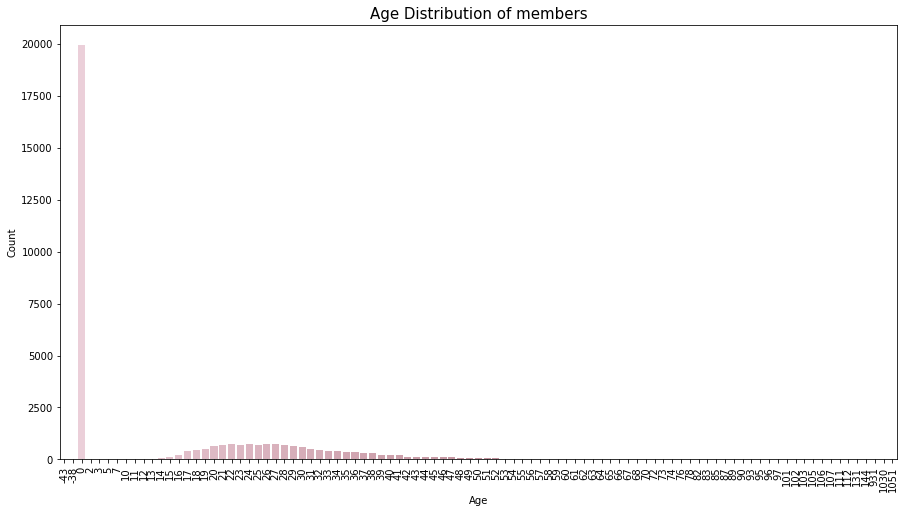

In [32]:
age = pd.DataFrame(members.groupby(['bd']).size()).reset_index(level=0)
age.columns = ['Age','Count']

sns_bar(age,'Age','Count','Age Distribution of members',col_pals[6],axis_rot=1)

# plt.figure(figsize=(15,8))
# ax = sns.histplot()

# plt.figure(figsize=(15,4))
# ax = sns.lineplot(data=resgistrations, color='#596657')
# ax.set(xlabel='Registration Date', ylabel='Count')
# ax.set_title('Distribution of Registration Date', fontsize=15)
# plt.show()

The age distribution plot above shows the outliers in member's age such as very small age(age =0) and extremly large age numbers (age>130)

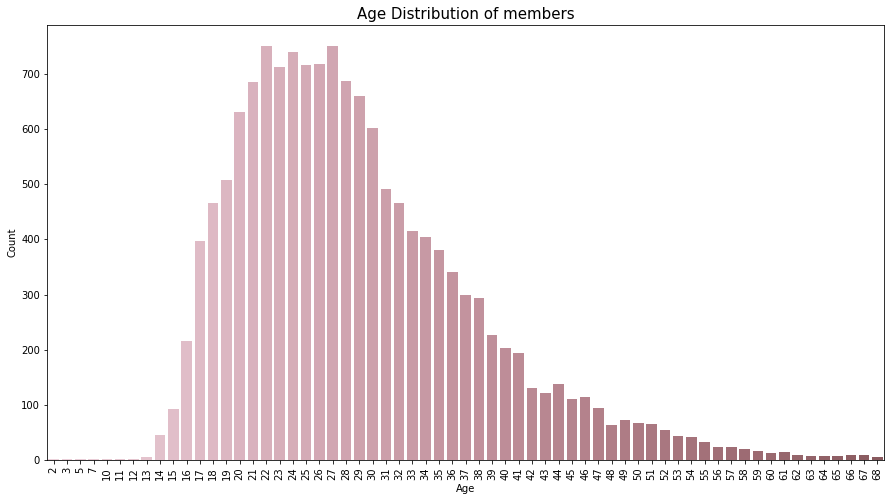

In [40]:
age_filtered = pd.DataFrame(members.groupby(['bd']).size()).reset_index(level=0)
age_filtered.columns = ['Age','Count']
age_filtered = age_filtered.loc[(age_filtered['Age'] > 0) & (age_filtered['Age'] < 70)]
sns_bar(age_filtered,'Age','Count','Age Distribution of members',col_pals[6],axis_rot=1)

if one sees the age distribution of member ages between 2 - 70 years, the distribution seems normal. 

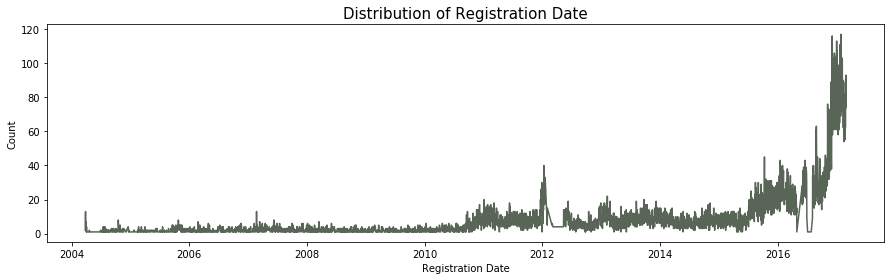

In [15]:
resgistrations = members['registration_init_time'].value_counts()
resgistrations.columns = ['Registration Date', 'Count']

plt.figure(figsize=(15,4))
ax = sns.lineplot(data=resgistrations, color='#596657')
ax.set(xlabel='Registration Date', ylabel='Count')
ax.set_title('Distribution of Registration Date', fontsize=15)
plt.show()

We can a spike in music app membership registration post 2015. The advent of music streaming technology can be one of the reason behind rise of application such as Kkbox or spotify making music available to masses.

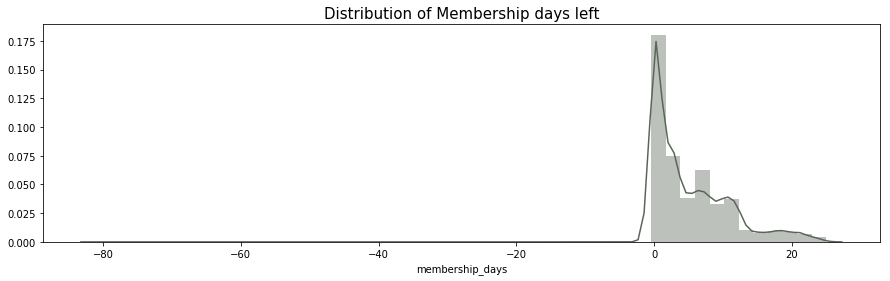

In [16]:
def add_days_left(train):
    train['membership_days'] = (train.expiration_date - train.registration_init_time).dt.days.astype('int')
    train['membership_days'] = train['membership_days']//200
    train['membership_days'] = train['membership_days'].astype('category')
    return train

membership = add_days_left(members)


plt.figure(figsize=(15,4))
ax = sns.distplot(membership.membership_days, color='#596657')
ax.set_title('Distribution of Membership days left', fontsize=15)
plt.show()

In [17]:
songs.head(5)

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language
0,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,247640,465,張信哲 (Jeff Chang),董貞,何啟弘,3.0
1,o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=,197328,444,BLACKPINK,TEDDY| FUTURE BOUNCE| Bekuh BOOM,TEDDY,31.0
2,DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=,231781,465,SUPER JUNIOR,NaN,NaN,31.0
3,dKMBWoZyScdxSkihKG+Vf47nc18N9q4m58+b4e7dSSE=,273554,465,S.H.E,湯小康,徐世珍,3.0
4,W3bqWd3T+VeHFzHAUfARgW9AvVRaF4N5Yzm4Mr6Eo/o=,140329,726,貴族精選,Traditional,Traditional,52.0


In [18]:
summary(songs)

Distinct features in dataframe:2296320
Distinct features in dataframe:146534
Distinct features in dataframe:1046
Distinct features in dataframe:222363
Distinct features in dataframe:329824
Distinct features in dataframe:110926
Distinct features in dataframe:11


In [19]:
count_na(songs)

song_id ....0 ....0.00%
song_length ....0 ....0.00%
genre_ids ....94116 ....4.10%
artist_name ....0 ....0.00%
composer ....1071354 ....46.66%
lyricist ....1945268 ....84.71%
language ....1 ....0.00%


The songs data has many higher missing values for columns composer and lyricist. 

Text(0.5, 1.0, 'What language songs do people listen')

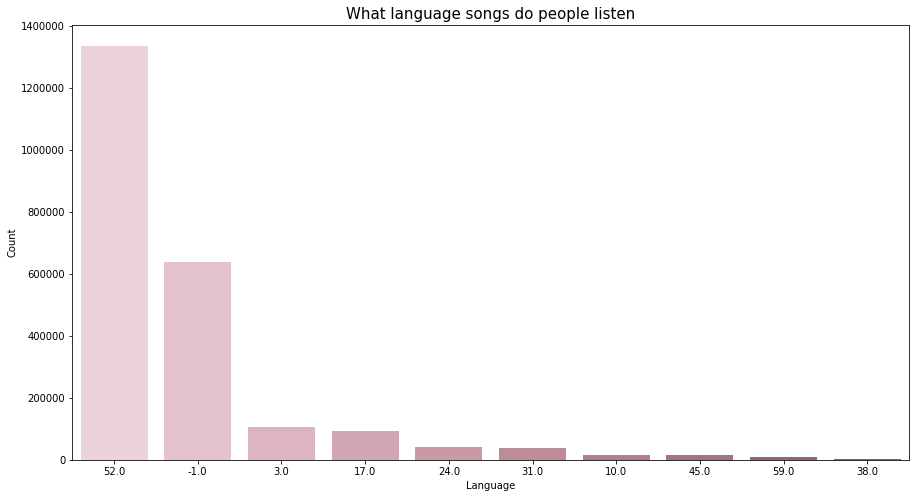

In [20]:
language = pd.DataFrame(songs.groupby(['language']).size()).reset_index(level=0)
language.columns = ['Language', 'Count']
language = language.sort_values(by='Count', ascending=False)
language['Language']=language['Language'].astype('str')

plt.figure(figsize=(15,8))
ax = sns.barplot(x='Language', y='Count', order=language['Language'],
                 data=language, palette=col_pals[6])
ax.set_title('What language songs do people listen', fontsize=15)

Mean song length in minutes: 4.12 mins
Number of songs which have length greater than 10 minutes:37274


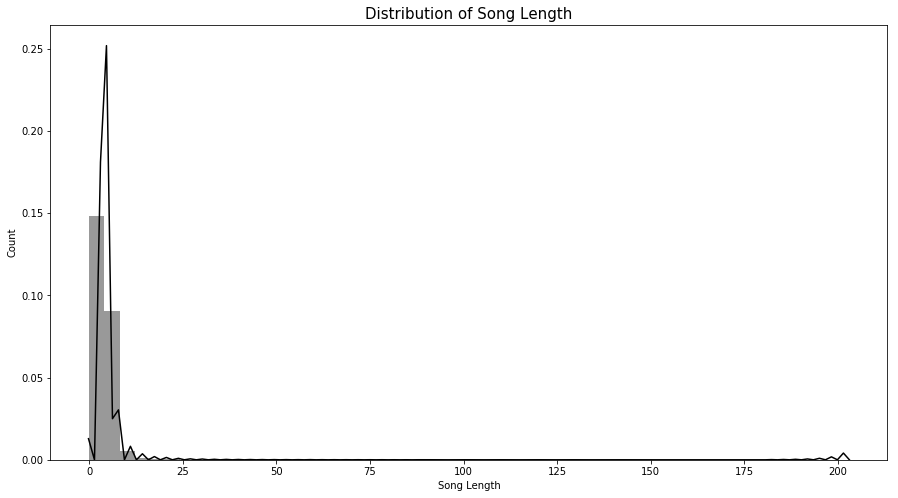

In [21]:
print("Mean song length in minutes: {} mins".format(round((songs.song_length/6e4).describe()[1],2)))
#print("\n")
print("Number of songs which have length greater than 10 minutes:{}".format(songs.query('song_length/6e4>10').shape[0]))
plt.subplots(figsize=(15, 8))
#x = ((songs.query('song_length/6e4<10')).song_length/6e4)
x = songs.song_length/6e4
ax = sns.distplot(x, color='black')
ax.set_title('Distribution of Song Length', fontsize=15)
ax.set(xlabel='Song Length', ylabel='Count')
plt.show()
# ax.savefig('song_length_wo_outliers.png')

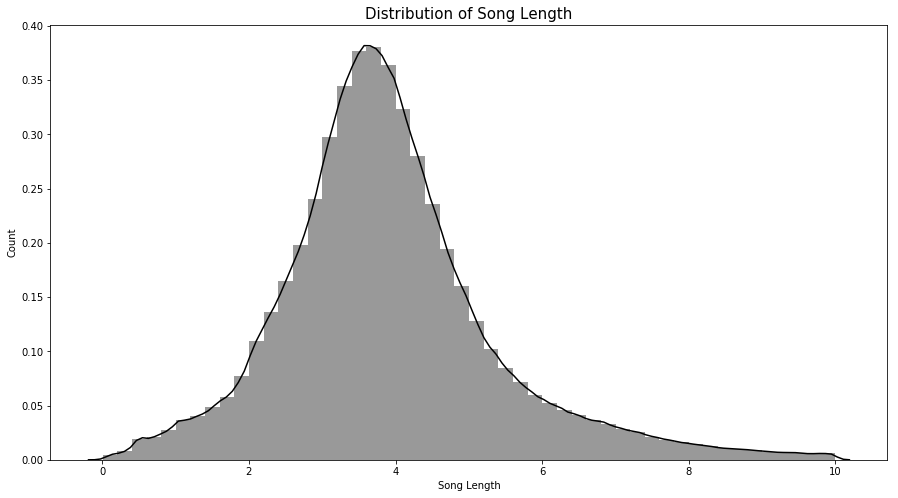

In [22]:
plt.subplots(figsize=(15, 8))
x = ((songs.query('song_length/6e4<10')).song_length/6e4)
#x = songs.song_length/6e4
ax = sns.distplot(x, color='black')
ax.set_title('Distribution of Song Length', fontsize=15)
ax.set(xlabel='Song Length', ylabel='Count')
plt.show()

In [31]:
# row=[]
# all=[]
# for i in range(len(extra_songs.name)):
#     try:
#         language = detect(extra_songs.name[i])
#     except:
#         language = "error"
#     row.append(language)
#     all.append(i)

In [25]:
def detect_language(p):
    try: 
        c = detec(p)
    except:
        c ="error"
        
    return c

extra_example = extra_songs.copy()
    
extra_example['language']= extra_songs['name'].apply(detect_language)
        
extra_example.head()

,song_id,name,isrc,language
0,LP7pLJoJFBvyuUwvu+oLzjT+bI+UeBPURCecJsX1jjs=,我們,TWUM71200043,error
1,ClazTFnk6r0Bnuie44bocdNMM3rdlrq0bCGAsGUWcHE=,Let Me Love You,QMZSY1600015,error
2,u2ja/bZE3zhCGxvbbOB3zOoUjx27u40cf5g09UXMoKQ=,原諒我,TWA530887303,error
3,92Fqsy0+p6+RHe2EoLKjHahORHR1Kq1TBJoClW9v+Ts=,Classic,USSM11301446,error
4,0QFmz/+rJy1Q56C1DuYqT9hKKqi5TUqx0sN0IwvoHrw=,愛投羅網,TWA471306001,error


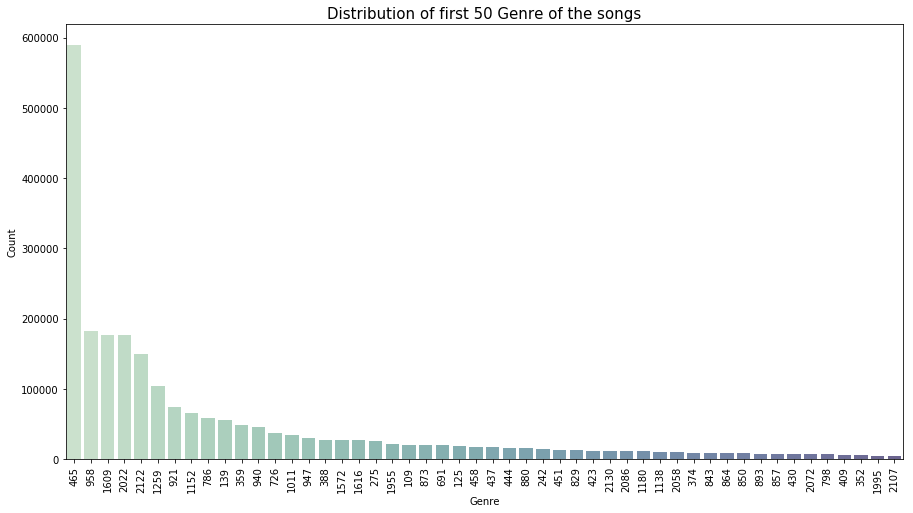

In [23]:
genre_df = pd.DataFrame.from_dict(genres_separate(songs.genre_ids),
                                     orient='index',
                                     columns=['Counts']).reset_index(level=0)
genre_df = genre_df.sort_values(by='Counts', ascending=False)
genre_df = genre_df[0:50]
genre_df.columns = ['Genre', 'Count']
genre_df['Genre']= genre_df['Genre'].astype('str')


plt.figure(figsize=(15,8))
ax = sns.barplot(x='Genre', y='Count', order=genre_df['Genre'],
                 data=genre_df, palette = "ch:7,-0.8,dark=.4")
ax.set_title('Distribution of first 50 Genre of the songs', fontsize=15)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

plt.show()

In [24]:
listen_log = train[['msno',
                    'song_id',
                    'target']].merge(songs[['song_id',
                                            'artist_name',
                                            'genre_ids',
                                            'language']],
                                             on='song_id')

In [25]:
print('10 Most repeated artists:')
listen_log[listen_log.target==1].groupby('artist_name').size().nlargest(10).reset_index(name='count')

10 Most repeated artists:


,artist_name,count
0,Various Artists,154799
1,周杰倫 (Jay Chou),112227
2,五月天 (Mayday),101027
3,林俊傑 (JJ Lin),67621
4,田馥甄 (Hebe),60481
5,玖壹壹,43964
6,陳奕迅 (Eason Chan),43895
7,aMEI (張惠妹),41498
8,G.E.M.鄧紫棋,41423
9,謝和弦 (R-chord),36423


In [26]:
print('10 Most skipped artists:')
listen_log[listen_log.target==0].groupby('artist_name').size().nlargest(10).reset_index(name='count')

10 Most skipped artists:


,artist_name,count
0,Various Artists,148817
1,五月天 (Mayday),81061
2,周杰倫 (Jay Chou),74549
3,林俊傑 (JJ Lin),47704
4,田馥甄 (Hebe),44465
5,aMEI (張惠妹),41301
6,陳奕迅 (Eason Chan),32140
7,BIGBANG,26610
8,玖壹壹,26481
9,G.E.M.鄧紫棋,25873


## Data Processing and Feature Engineering  <a class="anchor" id="fourth-bullet"></a>

Merging all the dataframes to create a training data. 

Re-classification of the data type in the dataframe

In [163]:
# Correction in column type
members.city = members.city.astype('category')
members.registered_via = members.registered_via.astype('category')
songs.language = songs.language.astype('category')

In [249]:
#song_cols = ['song_id', 'artist_name', 'genre_ids', 'song_length', 'language']
# Merge all data files
train_df = train.merge(songs, how='left', on='song_id')
train_df = train_df.merge(members, how='left', on='msno')
train_df = train_df.merge(extra_songs, how='left', on='song_id')

In [250]:
train_df.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,genre_ids,artist_name,composer,lyricist,language,city,bd,gender,registered_via,registration_init_time,expiration_date,name,isrc
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,206471.0,359,Bastille,Dan Smith| Mark Crew,NaN,52.0,1,0,NaN,7,2012-01-02,2017-10-05,Good Grief,GBUM71602854
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1,284584.0,1259,Various Artists,NaN,NaN,52.0,13,24,female,9,2011-05-25,2017-09-11,Lords of Cardboard,US3C69910183
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1,225396.0,1259,Nas,N. Jones、W. Adams、J. Lordan、D. Ingle,NaN,52.0,13,24,female,9,2011-05-25,2017-09-11,Hip Hop Is Dead(Album Version (Edited)),USUM70618761
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1,255512.0,1019,Soundway,Kwadwo Donkoh,NaN,-1.0,13,24,female,9,2011-05-25,2017-09-11,Disco Africa,GBUQH1000063
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1,187802.0,1011,Brett Young,Brett Young| Kelly Archer| Justin Ebach,NaN,52.0,1,0,NaN,7,2012-01-02,2017-10-05,Sleep Without You,QM3E21606003


In [ ]:
Converting 

In [251]:
train_df['song_length']=train_df['song_length']/6e4
#train['genre_ids'] = train['genre_ids'].str.split('|').str[0]

In [252]:
train_df['last_date'] = pd.to_datetime(train_df.registration_init_time.max(),format='%Y-%m-%d')
train_df.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,genre_ids,artist_name,composer,...,language,city,bd,gender,registered_via,registration_init_time,expiration_date,name,isrc,last_date
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,3.441183,359,Bastille,Dan Smith| Mark Crew,...,52.0,1,0,NaN,7,2012-01-02,2017-10-05,Good Grief,GBUM71602854,2017-01-31
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1,4.743067,1259,Various Artists,NaN,...,52.0,13,24,female,9,2011-05-25,2017-09-11,Lords of Cardboard,US3C69910183,2017-01-31
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1,3.756600,1259,Nas,N. Jones、W. Adams、J. Lordan、D. Ingle,...,52.0,13,24,female,9,2011-05-25,2017-09-11,Hip Hop Is Dead(Album Version (Edited)),USUM70618761,2017-01-31
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1,4.258533,1019,Soundway,Kwadwo Donkoh,...,-1.0,13,24,female,9,2011-05-25,2017-09-11,Disco Africa,GBUQH1000063,2017-01-31
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1,3.130033,1011,Brett Young,Brett Young| Kelly Archer| Justin Ebach,...,52.0,1,0,NaN,7,2012-01-02,2017-10-05,Sleep Without You,QM3E21606003,2017-01-31


In [253]:
def add_datepart(x,fldname):
    df = x.copy()
    
    if fldname =='registration_init_time':
        fldname_ = 'registration'
    else:
        fldname_ = fldname
    
    df[fldname_+"_year"] = df[fldname].apply(lambda x:int(str(x)[0:4]))
    df[fldname_+"_month"] = df[fldname].apply(lambda x:int(str(x)[5:7]))
    df[fldname_+"_date"] = df[fldname].apply(lambda x:int(str(x)[8:10]))
    
    return df

# Using isrc to extract years
def isrc_to_country(isrc):
    if type(isrc) == str:
        return isrc[0:2]
    else:
        return np.nan
    
def isrc_to_year(isrc):
    if type(isrc) == str:
        if int(isrc[5:7]) > 17:
            return 1900 + int(isrc[5:7])
        else:
            return 2000 + int(isrc[5:7])
    else:
        return np.nan

# Counted features
def genre_id_count(x):
    #https://www.kaggle.com/asmitavikas/feature-engineered-0-68310
    if pd.isnull(x):
        return -1
    else:
        return x.count('|')+1  

def artist_count(x):
    #https://www.kaggle.com/asmitavikas/feature-engineered-0-68310
    if pd.isnull(x):
        return -1
    else:
        return sum(map(x.count, ['|', '/', '\\', ';'])) + 1


def song_play_times(song_ids):
    #https://www.kaggle.com/asmitavikas/feature-engineered-0-68310
    song_play_dict = {}

    for song_id in song_ids:
        if song_id not in song_play_dict:
            song_play_dict[song_id] = 1
        else:
            song_play_dict[song_id] += 1
    
    return song_play_dict

In [254]:
# Fetaure addition 
def days_left(train):
    train['membership_days'] = (train.expiration_date - train.registration_init_time).dt.days.astype('int')
    train['membership_days'] = train['membership_days']//200
    train['membership_days'] = train['membership_days'].astype('category')
    train['registration_user'] = (train['last_date'] - train['registration_init_time']).dt.days.astype('int')
    train['expiration_user'] = (train['last_date'] - train['expiration_date']).dt.days.astype('int')
    return train

def genre_count(train):
    train['genre_count'] = train['genre_ids'].apply(genre_id_count).astype(np.int8)
    return train


def add_artist_count(train):
    train['artist_count'] = train['artist_name'].apply(artist_count).astype(np.int8)
    return train

def song_country(train):
    train['song_country'] = train['isrc'].apply(isrc_to_country)
    return train

def song_year(train):
    train['song_year'] = train['isrc'].apply(isrc_to_year)
    train.drop(['isrc', 'name'], axis = 1, inplace = True)
    return train


def song_play_count(train):

    songcount = train.groupby('song_id')[['msno']].count().reset_index()
    songcount.rename(columns={'msno': 'mnso_count'}, inplace=True)
    train=train.merge(songcount, on='song_id', how='left')
    return train

def artist_played_count(train):
    #https://github.com/AditiSharmaUSFCA/WSDS-KKBOX-s-Music-Recommendation-System
    artist_count = pd.DataFrame.from_dict(song_play_times(train['artist_name']),
                                      orient='index',columns=['artist_song_count']).reset_index()
    artist_count = artist_count.rename(columns={'index':'artist_name'})
    train = train.merge(artist_count,how='left',on='artist_name')
    return train  

def msno_appear_count(train):
    #https://github.com/AditiSharmaUSFCA/WSDS-KKBOX-s-Music-Recommendation-System
    usercount = train_df.groupby('msno')[['song_id']].count().reset_index()
    usercount.rename(columns={'song_id': 'song_count'}, inplace=True)
    train = train.merge(usercount,how='left',on='msno')
    return train  
    
    
def datepart_reg(train):
    train = add_datepart(train, 'registration_init_time')
    train = train.drop(['registration_init_time'], axis=1)
    return train

def datepart_exp(train):
    train = add_datepart(train,'expiration_date')
    train = train.drop(['expiration_date'], axis=1)
    return train


def split_genre_columns(train):
    df = train.copy()
    df['genre_ids'] = df['genre_ids'].astype(str)
    df = pd.concat([df,df['genre_ids'].str.split('|',expand=True)],axis=1)
    df = df.drop(columns='genre_ids',axis= 1)
    return df

In [255]:
# Apply features form pipeline
def apply_features(train, feature_list):
    #https://github.com/AditiSharmaUSFCA/WSDS-KKBOX-s-Music-Recommendation-System
    for i in feature_list:
        train = i(train)
    return train

In [256]:
def fillna_nan(df, cat_list, contlist):
    #https://github.com/AditiSharmaUSFCA/WSDS-KKBOX-s-Music-Recommendation-System
    train = df.copy()
    for col in cat_list:
        train[col] = train[col].fillna('nan')
    for col in contlist:
        train[col] = train[col].fillna(-1)
    return train

In [258]:
features_pipeline = [days_left, 
                     datepart_reg, 
                     datepart_exp, 
                     genre_count, 
                     add_artist_count,
                     song_country,
                     song_year,
                     msno_appear_count,
                     song_play_count, 
                     artist_played_count]

x = apply_features(train_df, features_pipeline)
x = split_genre_columns(x)

In [259]:
x.head(2).T

,0,1
msno,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=
song_id,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=
source_system_tab,explore,my library
source_screen_name,Explore,Local playlist more
source_type,online-playlist,local-playlist
target,1,1
song_length,3.44118,4.74307
artist_name,Bastille,Various Artists
composer,Dan Smith| Mark Crew,NaN
lyricist,NaN,NaN


In [134]:
df =x.copy()

In [135]:
# Data imputation block

cat_nan_list = ['msno', 'song_id', 'source_screen_name', 
    'source_system_tab', 'source_type', 
    'artist_name', 'gender']
cont_nan_list = ['song_length','language', 'song_year']

df = fillna_nan(df, cat_nan_list, cont_nan_list)

In [136]:
df['language']=df['language'].astype('int64')
df['song_year']=df['song_year'].astype('int64')
df['membership_days']=df['membership_days'].astype('int64')

df = df.iloc[:,:-8]

In [137]:
col_list = ['msno','song_id','source_system_tab','source_screen_name','source_type','artist_name','gender']

# Label encoding for the categorical varaibles 

def encoder(ls,data):
    le = preprocessing.LabelEncoder()
    for column_name in ls:
            if data[column_name].dtype.name in ['category','object']:
                data[column_name] = le.fit_transform(data[column_name].astype(str))

# Encode the data
encoder(col_list,df)

In [138]:
df = df.drop(columns=['source_system_tab_user_lev_c',
                      'source_screen_name_user_lev_c',
                      'source_type_user_lev_c',
                      'artist_name_user_lev_c'],axis=1)
df = df.fillna(-1)

In [139]:
df.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,artist_name,song_length,language,city,...,genre_count,artist_count,song_year,msno_appear_count,song_play_counts,artist_song_count,source_system_tab_count,source_screen_name_count,source_type_count,artist_name_count
0,8158,74679,1,7,7,1,3277,3.441183,52,1,...,1,1,2016,5511,215,1140,167949,72342,1967924,1140
1,17259,223479,3,8,4,1,31960,4.743067,52,13,...,1,1,1999,622,1,303616,3684730,3228202,1079503,303616
2,17259,120758,3,8,4,1,21372,3.756600,52,13,...,1,1,2006,622,4,289,3684730,3228202,1079503,289
3,17259,23707,3,8,4,1,27439,4.258533,-1,13,...,1,1,2010,622,1,1,3684730,3228202,1079503,1
4,8158,33308,1,7,7,1,4472,3.130033,52,1,...,1,1,2016,5511,412,427,167949,72342,1967924,427


In [140]:
from sklearn.model_selection import train_test_split
import random

# Features and target varaibles
X = df.drop(columns='target',axis=1)
y = df['target']

# Train and test split
X_train_all, X_test, y_train_all, y_test = train_test_split(X, y, test_size=0.2)

# Train and validation split
X_train, X_val, y_train, y_val = train_test_split(
    X_train_all, y_train_all, test_size=0.2)

# Sampled data
idx = random.sample(range(0,X_train.shape[0]), 100000)
X_train_sampled = X_train.iloc[idx]
y_train_sampled = y_train.iloc[idx]

In [141]:
from sklearn.metrics import accuracy_score
m = LogisticRegression()
m.fit(X_train_sampled, y_train_sampled )
predicted = m.predict(X_val)
accuracy = accuracy_score(y_val, predicted)
print(f'Mean accuracy score validation: {accuracy:.3}')

Mean accuracy score validation: 0.614


In [142]:
import lightgbm as lgb
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

#Fitting a model on sampled data
sk_reg = lgb.sklearn.LGBMClassifier(
         objective='binary',
         eval_metric='binary_logloss',
         boosting='gbdt',
         learning_rate=0.3 ,
         verbose=0,
         num_leaves=600,
         bagging_freq= 1,
         feature_fraction= 0.9,
         max_bin= 256,
         max_depth= 300,
         num_rounds= 200,
)


sk_reg.fit(X_train_sampled, y_train_sampled)

LGBMClassifier(bagging_freq=1, boosting='gbdt', boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0,
               eval_metric='binary_logloss', feature_fraction=0.9,
               importance_type='split', learning_rate=0.3, max_bin=256,
               max_depth=300, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=600,
               num_rounds=200, objective='binary', random_state=None,
               reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0, verbose=0)

In [143]:
predicted = sk_reg.predict(X_val)
accuracy = accuracy_score(y_val, predicted)
print(f'Mean accuracy score: {accuracy:.3}')

Mean accuracy score: 0.645


                               cols   imp
1                           song_id  9134
6                       song_length  8937
31                 song_play_counts  8374
0                              msno  8152
30                msno_appear_count  7951
5                       artist_name  7522
32                artist_song_count  7226
19    registration_init_timeElapsed  5700
16        registration_init_timeDay  5434
18  registration_init_timeDayofyear  4515


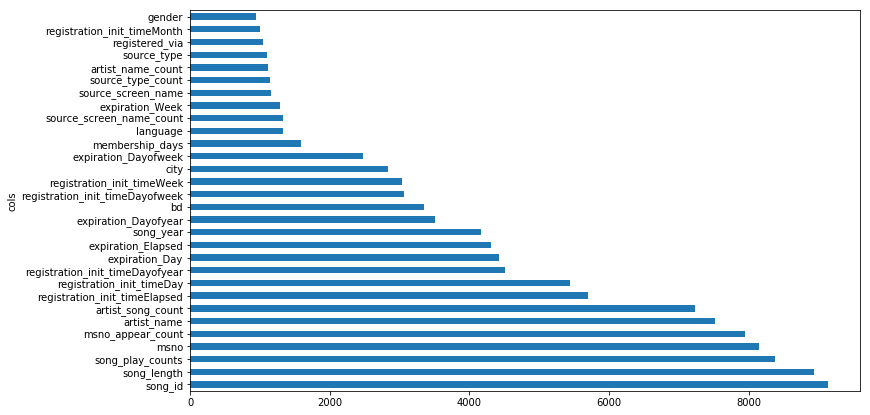

In [144]:
### Feature selection

def lgb_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

fi = lgb_feat_importance(sk_reg, X_train_sampled ); 
print(fi[:10])

def plot_fi(fi):return fi.plot('cols', 'imp', 'barh',
                               figsize=(12,7), legend=False)
plot_fi(fi[:30])
plt.show()

In [145]:
# Pipeline and grid search
pipe_dt = Pipeline([('clf', lgb.sklearn.LGBMClassifier())]) # Estimator: ML algorithm

grid_params = dict(
         clf__objective=['binary'],
         clf__eval_metric=['binary_logloss'],
         clf__boosting_type=['gbdt'],
         clf__learning_rate=[0.3] ,
         clf__verbose=[0],
         clf__num_leaves=[300, 350, 250],
         clf__feature_fraction= [0.9],
         clf__max_bin= [256],
         clf__max_depth= [200, 150, 250],
         clf__num_rounds= [200])
gs = GridSearchCV(estimator=pipe_dt,  
                  param_grid=grid_params,
                  scoring='accuracy',
                  cv=5)

gs.fit(X_train_sampled, y_train_sampled)
f"{gs.score(X_test, y_test):.4f}"

'0.6405'

In [146]:
# Best algorithm with best hyperparameters 
# (need to fit it to find specific model parameters)
print(gs.best_estimator_)

# Best model with specific model parameters
gs.best_estimator_.get_params()['clf']

Pipeline(memory=None,
         steps=[('clf',
                 LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                colsample_bytree=1.0,
                                eval_metric='binary_logloss',
                                feature_fraction=0.9, importance_type='split',
                                learning_rate=0.3, max_bin=256, max_depth=200,
                                min_child_samples=20, min_child_weight=0.001,
                                min_split_gain=0.0, n_estimators=100, n_jobs=-1,
                                num_leaves=300, num_rounds=200,
                                objective='binary', random_state=None,
                                reg_alpha=0.0, reg_lambda=0.0, silent=True,
                                subsample=1.0, subsample_for_bin=200000,
                                subsample_freq=0, verbose=0))],
         verbose=False)


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               eval_metric='binary_logloss', feature_fraction=0.9,
               importance_type='split', learning_rate=0.3, max_bin=256,
               max_depth=200, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=300,
               num_rounds=200, objective='binary', random_state=None,
               reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0, verbose=0)

In [147]:
#Fitting the best model on all the data
Final_model = lgb.sklearn.LGBMClassifier(objective='binary',
                                         eval_metric='binary_logloss',
                                         boosting='gbdt',
                                         learning_rate=0.3 ,
                                         verbose=0,
                                         num_leaves=600,
                                         bagging_freq= 1,
                                         feature_fraction= 0.9,
                                         max_bin= 256,
                                         max_depth= 300,
                                         num_rounds= 200)

In [148]:
#Validation accuracy
Final_model.fit(X_train, y_train)
predicted = Final_model.predict(X_val)
accuracy = accuracy_score(y_val, predicted)
print(f'Mean accuracy score on validation: {accuracy:.3}')

Mean accuracy score on validation: 0.734


In [149]:
# Predict probability for ROC curve
predicted = Final_model.predict_proba(X_test)

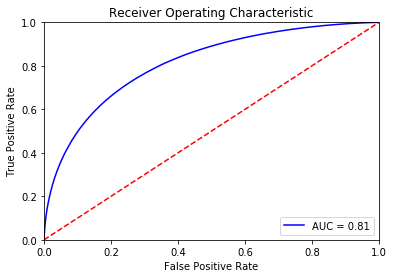

In [150]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

false_positive_rate, true_positive_rate, thresholds = roc_curve(
    y_test, [i[1]for i in predicted])
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate,
         'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()